In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.param[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Human SARS-Cov2 data from

*To, K. K. W., Tsang, O. T. Y., Leung, W. S., Tam, A. R., Wu, T. C., Lung, D. C., Yip, C. C. Y., Cai, J. P., Chan, J. M. C., Chik, T. S. H., Lau, D. P. L., Choi, C. Y. C., Chen, L. L., Chan, W. M., Chan, K. H., Ip, J. D., Ng, A. C. K., Poon, R. W. S., Luo, C. T., … Yuen, K. Y. (2020). Temporal profiles of viral load in posterior oropharyngeal saliva samples and serum antibody responses during infection by SARS-CoV-2: an observational cohort study. The Lancet Infectious Diseases, 20(5), 565–574. https://doi.org/10.1016/S1473-3099(20)30196-1*


## Data set

23 individuals with up to 10 observations.

In [5]:
RAWDATA = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[1]
COLS = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[2]
DataFrame(RAWDATA)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0,,,,,,,,,,,,,
2,1,5.21924,,,,,,,,,,,,
3,2,,,,,,,,8.42034,,,3.76403,,4.30903
4,3,4.77062,,,,,,,6.05675,,,,,
5,4,,,8.63656,,,,,6.21165,4.85564,6.04999,,,3.77379
6,5,,7.38193,,,6.6963,,,7.11621,6.68878,1,,,
7,6,1,7.35384,,,,,7.04338,1,,,,,
8,7,5.29376,,,,,,,4.7673,,,,,
9,8,1,,7.85297,8.4431,,,6.96152,5.14451,,,,,


In [6]:
DATA = copy(RAWDATA)
DATA[DATA .== ""] .= missing;

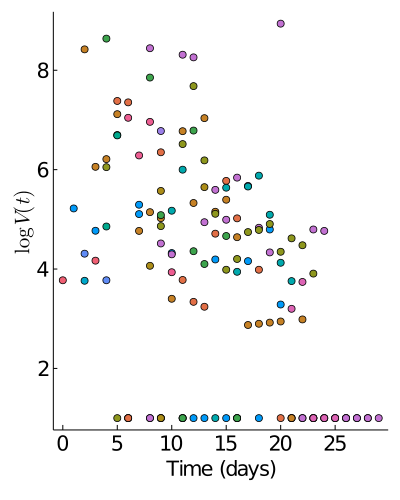

In [7]:
plt = plot(legend=:none, grid=:none, 
    xaxis=("Time (days)", font(14)), yaxis=(L"\log\,V(t)", font(14)), size=(400, 500), )
tdata = Float64.(DATA[:, 1])
[plot!(tdata, DATA[:, i], seriestype=:scatter) for i in 2:size(DATA, 2)]
savefig(figdir*"To2020Data.pdf")
display(plt)

Data points are all over the place.

### Average of data set


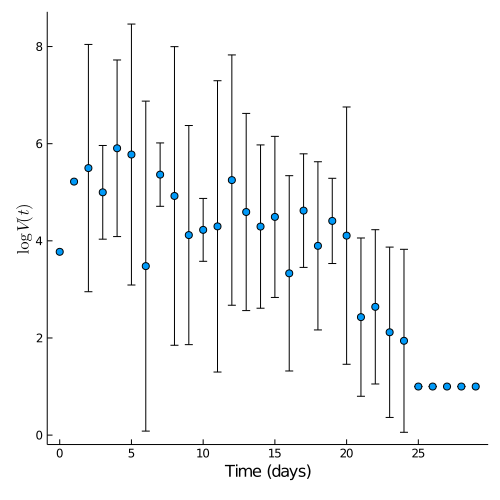

In [8]:
tdata = Float64.(DATA[:, 1])
vdata = [mean(skipmissing(DATA[i, 2:end])) for i in 1:size(DATA, 1)]
vstd = [std(skipmissing(DATA[i, 2:end])) for i in 1:size(DATA, 1)]
vcount = [count(DATA[i, 2:end] .!== missing) for i in 1:size(DATA, 1)]
plot(tdata, vdata, yerrors=vstd,
    seriestype=:scatter, legend=:none, grid=:none, size=(500, 500), 
    xlabel="Time (days)", ylabel=L"\log\,V(t)")
plot!()

Although the average data looks better, it doesn't really make sense to average the virus load per day since the each indivudual responds differently to the virus. This is way the standard deviation is large.

## Fitting the standard virus load function to each individual

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [9]:
DATA[[7,9, 10, 12, 13, 14, 16, 17, 19], 2] .= missing
DATA[[22, 23], 5] .= missing
DATA[[7, 22], 9] .= missing
DATA[[6, ], 11] .= missing
DATA[[25, 26], 16] .= missing
DATA[[17, ], 17] .= missing
DATA[[7, ], 19] .= missing
DATA[[12, ], 20] .= missing
DATA[[9, 10], 21] .= missing
DATA[[1, 30], 2:end] .= 1.;


Subject no.: 1
RSS = 1.47179e+00 (convergence: false)
  a₁ = 0.000e+00 (CI=(-1.257e+09, 1.257e+09), initial=2.614e-01)

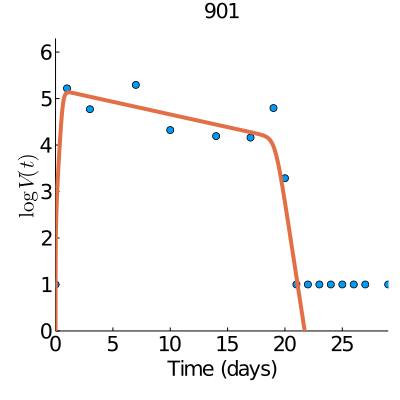


  a₂ = 1.252e+00 (CI=(-1.946e+08, 1.946e+08), initial=2.242e+00)
  b₁ = 1.749e+01 (CI=(1.540e+01, 1.958e+01), initial=1.539e+01)
  b₂ = 2.082e+01 (CI=(2.011e+01, 2.152e+01), initial=1.958e+01)
  α = 1.255e-01 (CI=(-9.270e-02, 3.437e-01), initial=8.000e-01)
  logVmax = 5.136e+00 (CI=(-2.328e+06, 2.328e+06), initial=7.800e+00)

Subject no.: 

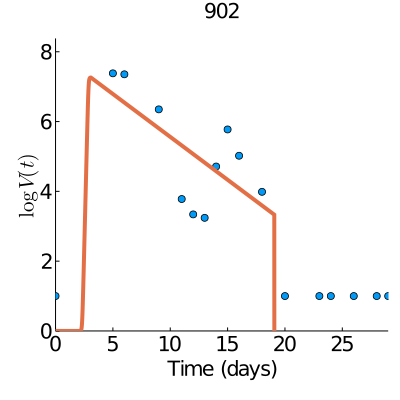

2
RSS = 1.22739e+01 (convergence: true)
  a₁ = 2.677e+00 (initial=4.952e-01)
  a₂ = 3.076e+00 (initial=4.860e+00)
  b₁ = 1.908e+01 (initial=1.260e+01)
  b₂ = 1.908e+01 (initial=2.556e+01)
  α = 5.660e-01 (initial=8.000e-01)
  logVmax = 7.263e+00 (initial=7.800e+00)


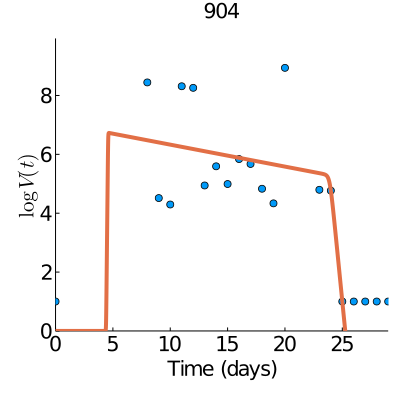


Subject no.: 4
RSS = 3.67542e+01 (convergence: true)
  a₁ = 4.517e+00 (initial=4.517e+00)
  a₂ = 4.659e+00 (initial=4.585e+00)
  b₁ = 2.323e+01 (initial=1.805e+01)
  b₂ = 2.458e+01 (initial=2.894e+01)
  α = 1.717e-01 (initial=8.000e-01)
  logVmax = 6.728e+00 (initial=7.800e+00)

Subject no.: 

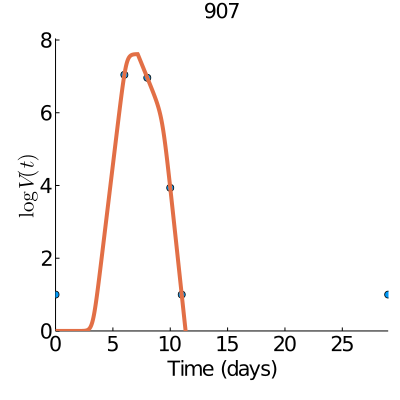

7
RSS = 0.00000e+00 (convergence: true)
  a₁ = 5.169e+00 (initial=5.175e+00)
  a₂ = 7.162e+00 (initial=7.516e+00)
  b₁ = 8.131e+00 (initial=8.677e+00)
  b₂ = 1.053e+01 (initial=1.238e+01)
  α = 1.788e+00 (initial=8.000e-01)
  logVmax = 7.613e+00 (initial=7.800e+00)


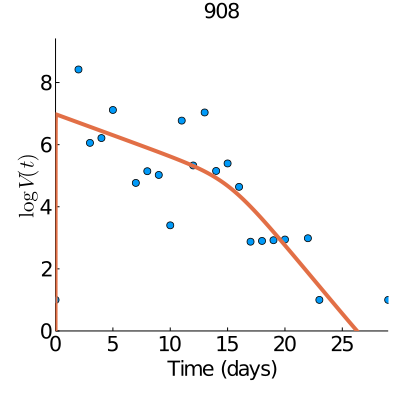


Subject no.: 8
RSS = 2.07736e+01 (convergence: true)
  a₁ = 0.000e+00 (CI=(-1.896e+10, 1.896e+10), initial=3.925e-02)
  a₂ = 4.006e-02 (CI=(-1.809e+10, 1.809e+10), initial=4.087e-02)
  b₁ = 6.716e+00 (CI=(-1.419e+01, 2.762e+01), initial=8.012e+00)
  b₂ = 2.356e+01 (CI=(1.060e+01, 3.651e+01), initial=2.351e+01)
  α = 3.114e-01 (CI=(-2.554e-01, 8.782e-01), initial=8.000e-01)
  logVmax = 6.977e+00 (CI=(-6.873e+09, 6.873e+09), initial=7.800e+00)

Subject no.: 

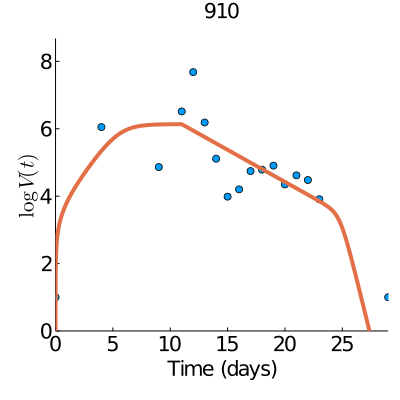

10
RSS = 9.03262e+00 (convergence: true)
  a₁ = 0.000e+00 (CI=(-1.636e+01, 1.636e+01), initial=4.958e+00)
  a₂ = 1.100e+01 (CI=(-1.235e+00, 2.324e+01), initial=9.193e+00)
  b₁ = 2.263e+01 (CI=(-1.821e+03, 1.867e+03), initial=2.053e+01)
  b₂ = 2.702e+01 (CI=(-1.869e+04, 1.874e+04), initial=2.474e+01)
  α = 4.384e-01 (CI=(-3.835e-02, 9.151e-01), initial=8.000e-01)
  logVmax = 6.138e+00 (CI=(4.248e+00, 8.027e+00), initial=7.800e+00)


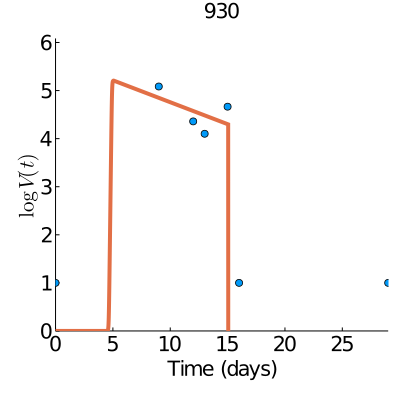


Subject no.: 19
RSS = 3.80628e-01 (convergence: true)
  a₁ = 4.781e+00 (initial=4.781e+00)
  a₂ = 5.061e+00 (initial=5.322e+00)
  b₁ = 1.505e+01 (initial=7.935e+00)
  b₂ = 1.505e+01 (initial=2.217e+01)
  α = 2.100e-01 (initial=8.000e-01)
  logVmax = 5.208e+00 (initial=7.800e+00)

Subject no.: 

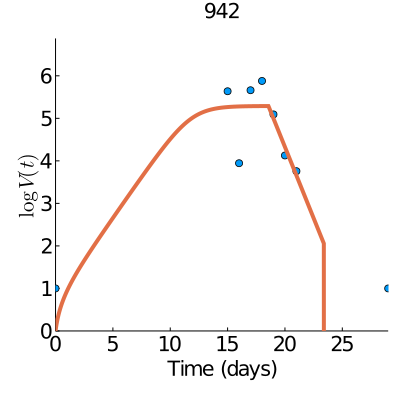

22
RSS = 2.46967e+00 (convergence: true)
  a₁ = 5.060e+00 (initial=7.119e+00)
  a₂ = 1.856e+01 (initial=1.912e+01)
  b₁ = 2.339e+01 (initial=2.055e+01)
  b₂ = 2.339e+01 (initial=2.623e+01)
  α = 1.542e+00 (initial=8.000e-01)
  logVmax = 5.290e+00 (initial=7.800e+00)

Data & $\mx$ & $\mn$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ \\ 
901 & 1.37 $\cdot 10^{5}$ & $10^{-7$ & 0.00 & 1.25 & 0.13 & 17.49 & 20.82 \\ 
902 & 1.83 $\cdot 10^{7}$ & $10^{-7$ & 2.68 & 3.08 & 0.57 & 19.08 & 19.08 \\ 
904 & 5.34 $\cdot 10^{6}$ & $10^{-7$ & 4.52 & 4.66 & 0.17 & 23.23 & 24.58 \\ 
907 & 4.10 $\cdot 10^{7}$ & $10^{-7$ & 5.17 & 7.16 & 1.79 & 8.13 & 10.53 \\ 
908 & 9.48 $\cdot 10^{6}$ & $10^{-7$ & 0.00 & 0.04 & 0.31 & 6.72 & 23.56 \\ 
910 & 1.37 $\cdot 10^{6}$ & $10^{-7$ & 0.00 & 11.00 & 0.44 & 22.63 & 27.02 \\ 
930 & 1.61 $\cdot 10^{5}$ & $10^{-7$ & 4.78 & 5.06 & 0.21 & 15.05 & 15.05 \\ 
942 & 1.95 $\cdot 10^{5}$ & $10^{-7$ & 5.06 & 18.56 & 1.54 & 23.39 & 23.39 \\ 


6×8 Array{Any,2}:
  0.0        2.67737    4.51673    5.1688    0.0         0.0        4.78117    5.05972
  1.25188    3.07619    4.65874    7.16237   0.0400591  11.0        5.06132   18.5615
 17.4891    19.0773    23.2291     8.13066   6.71627    22.6327    15.0526    23.3923
 20.8168    19.0773    24.5829    10.5279   23.5554     27.0216    15.0526    23.3923
  0.125522   0.565978   0.171722   1.78842   0.311414    0.438379   0.210004   1.5419
  5.13602    7.26265    6.72778    7.61268   6.97677     6.13758    5.20787    5.28985

In [10]:
params = []
tdata = Float64.(DATA[:, 1])
for subject in 2:size(DATA, 2)
    idx = DATA[:, subject] .!== missing
    if sum(idx) < 6
        continue
    end
    ttdata = tdata[idx]
    vvdata = Float64.(DATA[idx, subject])
    data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
    resultVLF = nothing
    for iter = 1:10000
        #       a₁,    a₂,    b₁,    b₂,        α,    logVmax
        par0 = vcat(sort(data.t[end]*rand(4)), [0.80, 7.8])
        result = try 
            VirusLoadCurve.fitVLF(data, par0)
        catch
            nothing
        end
        if result != nothing
            if resultVLF == nothing
                resultVLF = result
            else
                if sum(abs2, result.fit.resid) < sum(abs2, resultVLF.fit.resid)
                    resultVLF = result
                end
            end
        end
    end
    params = vcat(params, resultVLF.fit.param)
    println("\nSubject no.: ", subject-1)
    summary(resultVLF)
    VLFResultsLatex(COLS[subject], resultVLF)
    pt = plot(data)
    plot!(pt, resultVLF)
    plot!(pt, legend=false)
    title!(pt, string(COLS[subject]))
    savefig(figdir*"To2020-"*string(subject, pad=2)*".png")
    savefig(figdir*"To2020-"*string(subject, pad=2)*".pdf")
    display(pt)
end
print(read(io, String))
params = reshape(params, (6, 8))

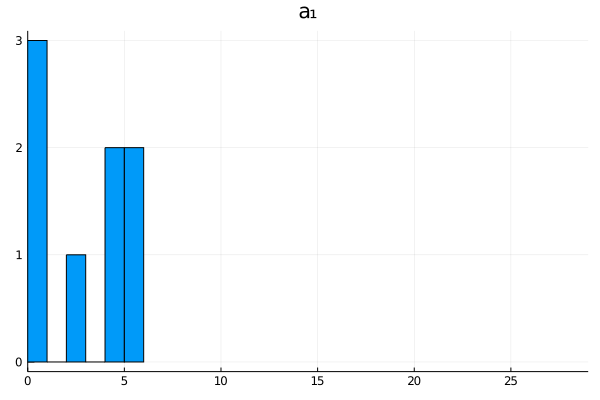

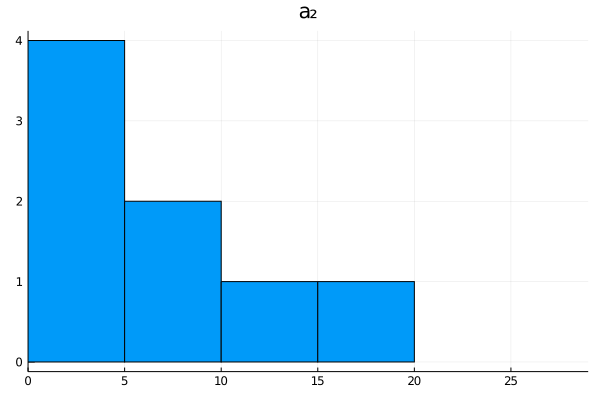

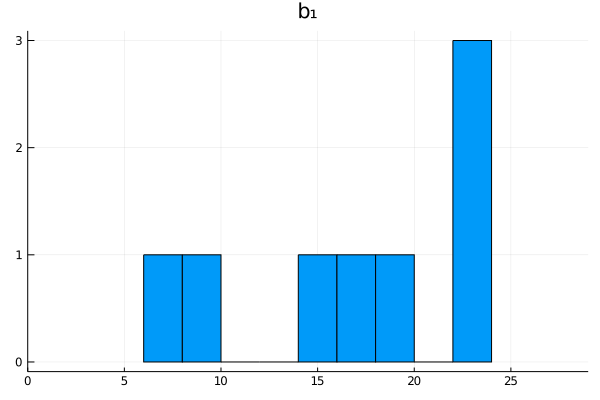

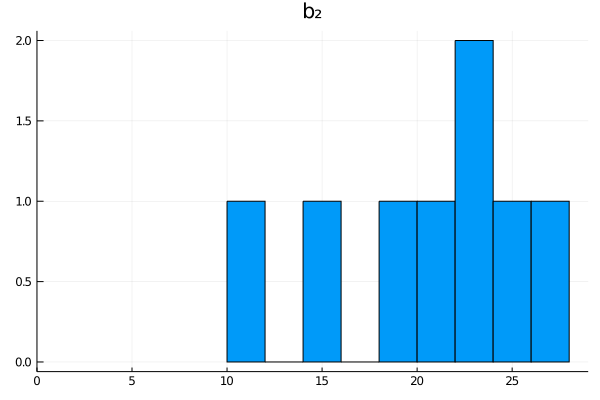

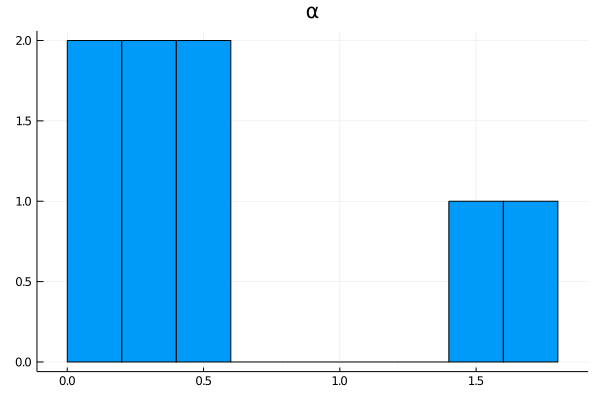

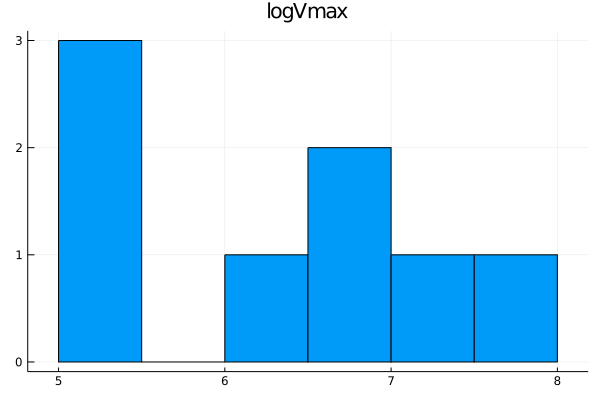

2-element Array{Nothing,1}:
 nothing
 nothing

In [11]:
parnames = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"]
[display(histogram(params[i, :], bins=8, leg=false, title=parnames[i], xlims=extrema(tdata))) for i in 1:4]
[display(histogram(params[i, :], bins=8, leg=false, title=parnames[i])) for i in 5:6]